### Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.vision import *
from fastai import *
from fastai.callbacks.tracker import SaveModelCallback, ReduceLROnPlateauCallback
import os, sys
import warnings
import cv2
import torchvision.models as tmodels
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
np.random.seed(42)

In [0]:
path = Path('/content/drive/My Drive/Colab Notebooks/data/cameras')
#path.ls()
path_png = Path('/content/drive/My Drive/Colab Notebooks/data/cameras_png/pics')
# path_png.ls()

default databunch used for benchmarks 

In [0]:
def get_data(tfms=None, size=224, bs=32, partial_data=1., path=Path('/content/drive/My Drive/Colab Notebooks/data/cameras')):
    return (ImageList.from_folder(path)
            .use_partial_data(partial_data)
            .split_by_rand_pct(valid_pct=0.2)            
            .label_from_folder()
            .transform(tfms, size=size) #future add tfms
            .databunch(bs=bs, no_check=True))

### Grand finale

In [0]:
def _compress(x, quality:uniform):
  quality_flag = cv2.IMWRITE_JPEG_QUALITY
  x = x.permute(2,1,0).numpy()
  x = x*255
  x = x.astype(np.uint8)
  _, encoded_img = cv2.imencode('.jpg', x, (int(quality_flag), quality))
  x = cv2.imdecode(encoded_img, cv2.IMREAD_UNCHANGED)
  x = x.astype(np.float32)
  x = x/255
  b = torch.from_numpy(x)
  b = b.permute(2,1,0)
  return b
compress = TfmPixel(_compress)

In [0]:
tfms = get_transforms(max_zoom=.0, xtra_tfms=compress(quality=(90,100), p=0.75))

In [0]:
tfms = get_transforms(max_zoom=.0)

In [0]:
tfms[0].pop(5); tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (compress), kwargs={'quality': (90, 100)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [0]:
data = get_data(tfms=tfms, size=(375,500), bs=64, path=path, partial_data=1)

In [0]:
img_stats = data.batch_stats()
data.normalize(img_stats)

ImageDataBunch;

Train: LabelList (1752 items)
x: ImageList
Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500)
y: CategoryList
casio,agfa,samsung,samsung,pentax
Path: /content/drive/My Drive/Colab Notebooks/data/cameras;

Valid: LabelList (437 items)
x: ImageList
Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500)
y: CategoryList
agfa,olympus,samsung,canon,kodak
Path: /content/drive/My Drive/Colab Notebooks/data/cameras;

Test: None

In [0]:
data.show_batch(rows=3)

In [0]:
resnext50_32x4d = tmodels.resnext50_32x4d(pretrained=True)

In [0]:
learn = Learner(data, resnext50_32x4d, metrics=accuracy).batch_loss_filter().to_fp16()

In [0]:
learn.summary()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


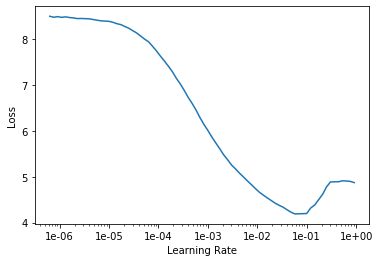

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10,3e-3, callbacks=[SaveModelCallback(learn, name='newbest', every='epoch', monitor='accuracy')])

In [0]:
learn.load('newbest_2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


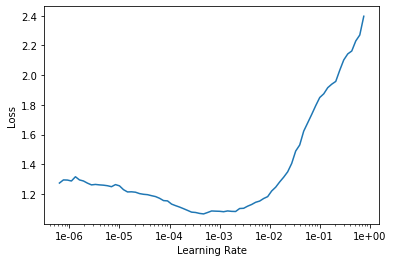

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8,6e-4, callbacks=[SaveModelCallback(learn, name='newbest', every='epoch', monitor='accuracy')])

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#tu był zgubiony trening

In [0]:
learn.load('bestmodel_7')

In [0]:
learn.validate()

[0.4968717, tensor(0.8381)]

In [0]:
learn.show_results()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_confusion_matrix()

### Create DataBunch obj

In [0]:
data = get_data(size=(375,500))

In [0]:
data = get_data(bs=64, partial_data=0.2, path=path_png)

In [0]:
data.classes, data.c

(['agfa',
  'canon',
  'casio',
  'fujifilm',
  'kodak',
  'nikon',
  'olympus',
  'panasonic',
  'pentax',
  'samsung',
  'sony'],
 11)

In [0]:
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

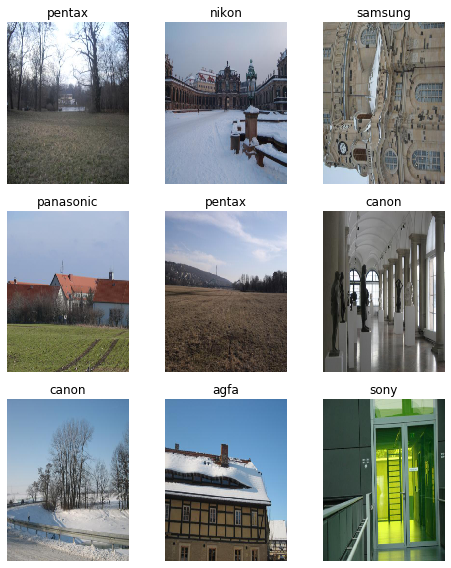

In [0]:
data.show_batch(rows=3)

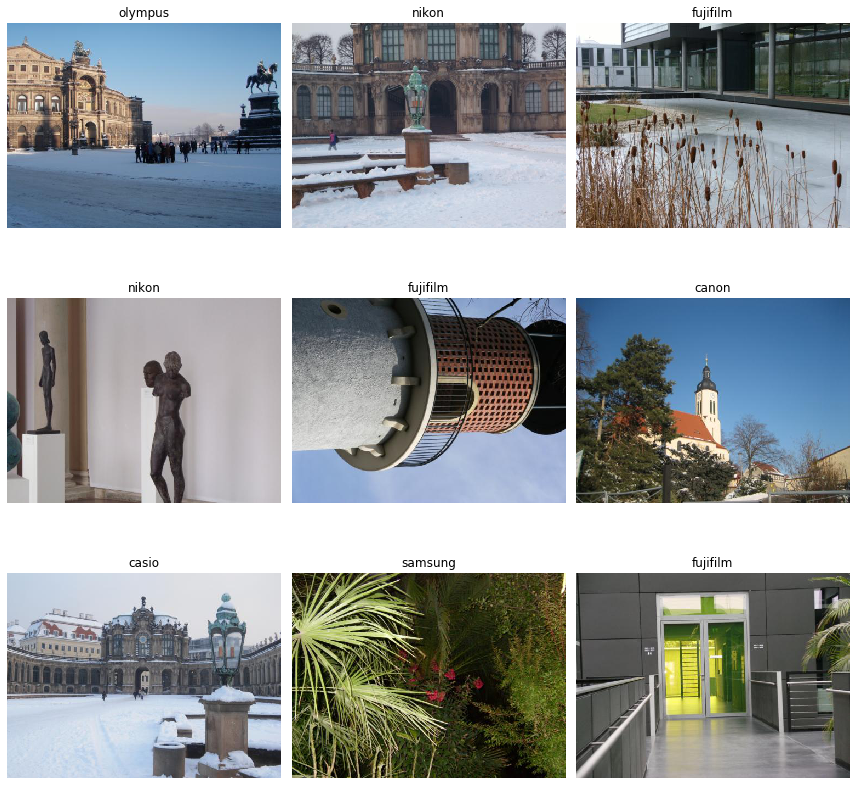

In [0]:
data.show_batch(rows=3)

#### Test

In [0]:
def test(name, learn=cnn_learner(data, models.resnet50, metrics=accuracy)):
  learn.unfreeze()
  learn.fit_one_cycle(5)
  # learn.save(name)
#   interp = ClassificationInterpretation.from_learner(learn)
#   interp.plot_confusion_matrix()

### Baseline

In [0]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)

In [0]:
data = get_data(bs=64)
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


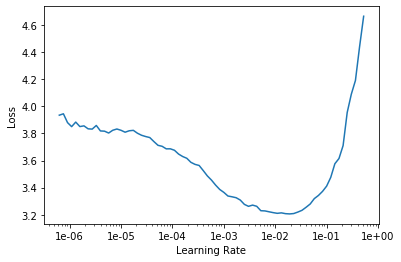

In [0]:
learn.recorder.plot()

In [0]:
save_model = partial(SaveModelCallback, learn, every='improvement', monitor='accuracy')

In [0]:
learn.fit_one_cycle(20, 8e-4, div_factor=10, pct_start=0.3)

#### Test on FP16 
rumor has it that fp16 can improve converging
##problem: fp16 works only on kernels 3x3

In [0]:
data = get_data()
learn_fp = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()
learn_fp.unfreeze()
learn_fp.fit_one_cycle(20, 1e-4, div_factor=10, pct_start=0.3)

#### Test on full resolution images 
(375, 375) and (375, 500)
we should get better results, with longer learning

In [0]:
data = get_data(size=375)
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
test("resnet50-full", learn)

#### Test normalization (shouldn't be worse)

In [0]:
data = get_data(bs=64)
img_stats = data2.batch_stats()
data.normalize(img_stats)
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
test("resnet50-norm", learn)

### Different architectures

####Downloads


In [0]:
import torchvision.models as models

In [0]:
data = get_data(bs=32)

In [0]:
# densenet = models.densenet161(pretrained=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


####DenseNet

In [0]:
data = get_data(bs=16)

In [0]:
learnDense = Learner(data, densenet, metrics=accuracy)
learnDense.unfreeze()

In [0]:
learnDense.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


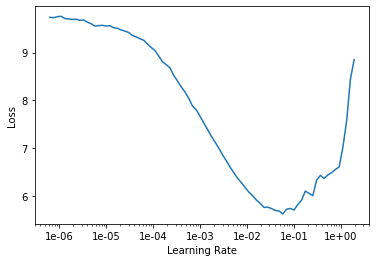

In [0]:
learnDense.recorder.plot()

In [0]:
learnDense.fit_one_cycle(20, 1e-3, div_factor=10, pct_start=0.3)

####ResNext

In [0]:
data = get_data(bs=32)

In [0]:
learnNext = Learner(data, resnext50_32x4d, metrics=accuracy)

In [0]:
learnNext.unfreeze()

In [0]:
learnNext.fit_one_cycle(20, 3e-3, div_factor=10, pct_start=0.3)

####ResNet

In [0]:
learnResNet = Learner(data, resnet50, metrics=accuracy)

In [0]:
learnResNet.unfreeze()

In [0]:
learnResNet.fit_one_cycle(20, 3e-3, div_factor=10, pct_start=0.3)

#### WideResnet

In [0]:
data = get_data(bs=32)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
learnWide = Learner(data, wide_resnet50_2, metrics=accuracy)
learnWide.unfreeze()

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:04<00:00, 28.6MB/s]


In [0]:
learnWide.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


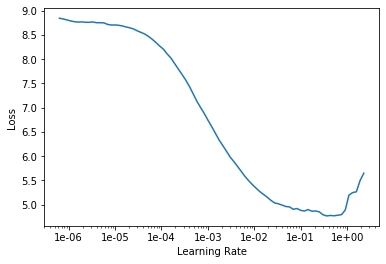

In [0]:
learnWide.recorder.plot()

In [0]:
learnWide.fit_one_cycle(20, 3e-3, div_factor=10, pct_start=0.3)

### Test on Ranger and Mish
different optimizer and activation function

In [0]:
!git clone https://github.com/sdoria/mish

Cloning into 'mish'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 46 (delta 21), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [0]:
%cd mish
from rangerlars import *
from mish import *
from mxresnet import *
from ranger import *
%cd ..

/content/mish
Mish activation loaded...
/content


#### Baseline

In [0]:
data3 = get_data(bs=64)
opt_func3 = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)
learn3 = Learner(data3, models.xresnet50(c_out=data3.c), wd=1e-2, opt_func=opt_func3,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy])

In [0]:
learn3.fit_one_cycle(20, 8e-4, div_factor=10, pct_start=0.3)

we should take a closer look at the results, although accuracy is lower than in the default we should check how default will perfom without transfer learning

In [0]:
data = get_data(bs=64)
learn = cnn_learner(data, models.resnet50, pretrained=False, metrics=[accuracy])

In [0]:
learn.fit_one_cycle(20, 3e-3, div_factor=10, pct_start=0.3)

dramatically bad :(

In [0]:
learn = cnn_learner(data, models.resnet50, wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy])

In [0]:
learn.summary()

#### Ranger

In [0]:
opt_func = partial(Ranger, betas=(0.9,0.99), eps=1e-6)


In [0]:
learn = Learner(data, models.xresnet50(c_out=data.c), wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy, top_k_accuracy])

Another thing is that one_cycle is designed to perform well with Adam, whitch is not the case with Ranger

In [0]:
learn.fit_one_cycle(20, 8e-4, div_factor=10, pct_start=0.3)

In [0]:
learn.fit_one_cycle(20, 3e-3, div_factor=10, pct_start=0.3)

#### Ranger + Flatten Anneal
best results we can get according to ImageWoof competition

In [0]:
from fastai.callbacks import *

In [0]:
def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float):
  n = len(learn.data.train_dl)
  anneal_start = int(n*n_epochs*start_pct)
  anneal_end = int(n*n_epochs) - anneal_start
  phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
           TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
  sched = GeneralScheduler(learn, phases)
  learn.callbacks.append(sched)
  learn.fit(n_epochs)

In [0]:
opt_func = partial(Ranger, betas=(0.95,0.99), eps=1e-6)
learn = Learner(data, models.xresnet50(c_out=data.c), wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy, top_k_accuracy])

In [0]:
flattenAnneal(learn, 8e-4, 20, 0.72)

Except flattenAnneal I'm adding SelfAttention layer.

"The self attention layer is designed to help leverage long range dependencies within an image vs the more local feature focus of convolutions."
[paper](https://arxiv.org/pdf/1805.08318.pdf)




#### Ranger + FlattenAnneal + MxResnet





I bet that if dataset was bigget this would be the best method because mish propagates better in the net

Another problem is time, I don't know exactly why but mish is calcultaing way to slow

In [0]:
opt_func = partial(Ranger, betas=(0.9,0.99), eps=1e-6)
learn = Learner(data, mxresnet50(c_out=data.c), wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy, top_k_accuracy])

In [0]:
flattenAnneal(learn, 4e-3, 5, 0.7)

it appears that mish activation function is slowing down 3 times training process, how people in paper are achieving nearly the same time in both cases?

#### Ranger + MxResnet

In [0]:
opt_func = partial(Ranger, betas=(0.9,0.99), eps=1e-6)
learn = Learner(data, mxresnet50(c_out=data.c), wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy, top_k_accuracy])

In [0]:
learn.fit_one_cycle(20, 3e-3, div_factor=10, pct_start=0.3)

### Tests on image transformations

In [0]:
import matplotlib.pyplot as plt
import cv2

#### Whole testing framework

In [0]:
class TestingFramework:
  def __init__(self, sample_number=25, epochs=5):
    self.sample_number = sample_number
    self.epochs = epochs

  def _step(self, scope, number):
    return (scope[1] - scope[0])/number

  def _train(self, tfms):
    data = get_data(tfms=tfms)
    learn = cnn_learner(data, models.resnet50, metrics=accuracy, silent=True)
    learn.unfreeze()
    learn.fit_one_cycle(self.epochs)
    # accuracy = learn.recorder.metrics[-1][0]
    # del learn
    return learn.recorder.metrics[-1][0]

  def test(self, tfms_source):
    tfms, y = tfms_source(self._step, self.sample_number)
    result = []
    for t in tfms:
      acc = self._train(t)
      result.append(acc)
    self._plot(result, y, tfms_source.__name__, "accuracy")

  def _plot(self, acc, scope, xname, yname):
    plt.plot(scope, acc)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.show()

In [0]:
#tfmsLighting = lambda max_lighting, p_lighting: ([brightness(change=(0.5-max_lighting, 0.5-max_lighting), p=p_lighting)],[crop_pad()])

In [0]:
def _compress(x, quality:uniform):
  quality_flag = cv2.IMWRITE_JPEG_QUALITY
  x = x.permute(2,1,0).numpy()
  x = x*255
  x = x.astype(np.uint8)
  _, encoded_img = cv2.imencode('.jpg', x, (int(quality_flag), quality))
  x = cv2.imdecode(encoded_img, cv2.IMREAD_UNCHANGED)
  x = x.astype(np.float32)
  x = x/255
  b = torch.from_numpy(x)
  b = b.permute(2,1,0)
  return b
compress = TfmPixel(_compress)

#### Testing if transformations work

In [0]:
def get_ex():
  return data.train_ds[0][0]

In [0]:
get_ex().show(figsize=(10,10))

In [0]:
tfmsCompression = lambda quality: ([compress(quality=quality)],[crop_pad()])

In [0]:
get_ex().apply_tfms(tfmsCompression(90)[0]).show(figsize=(10,10))

In [0]:
tfmsCompression(0.9)

([RandTransform(tfm=TfmPixel (compress), kwargs={'quality': 0.9}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [0]:
get_ex().apply_tfms(tfmsZoomCrop(2)[0])

In [0]:
get_ex().apply_tfms(tfmsCompression(0.5)[0])

#### Transformations generators

In [0]:
tester = TestingFramework(25, 10)

In [0]:
tfmsBrightness = lambda max_lighting: ([brightness(change=(max_lighting, max_lighting), p=1)],[crop_pad()]) 
tfmsZoom = lambda scale: ([zoom(scale=scale)],[crop_pad()]) 
tfmsZoomCrop = lambda scale: (zoom_crop(scale=(scale,scale),do_rand=True),[crop_pad()]) 
tfmsContrast = lambda scale: ([contrast(scale=(scale,scale), p=1)],[crop_pad()]) 
tfmsWarp = lambda max_warp: ([symmetric_warp(magnitude=(-max_warp,max_warp), p=1)],[crop_pad()])
tfmsRotate = lambda max_rotate: ([rotate(degrees=(-max_rotate, max_rotate), p=1)],[crop_pad()]) 
tfmsCompression = lambda quality: ([compress(quality=quality)],[crop_pad()])

In [0]:
class tfmGen:
    def __init__(self, name, scope, source):
        self.__name__ = name
        self.scope = scope
        self.source = source

    def __call__(self, steper, samples):
        step = steper(self.scope, samples)
        t_list = np.arange(self.scope[0]+step/2, self.scope[1]+step/2, step)
        tfms = [self.source(t) for t in t_list]

        return (tfms, t_list)

In [0]:
brightnessGen = tfmGen("brightness", (0,1), tfmsBrightness)
zoomGen     = tfmGen("zoom", (0.75, 2),tfmsZoom)
zoomCropGen = tfmGen("zoom crop", (0.75, 2), tfmsZoomCrop)
contrastGen = tfmGen("contrast", (0.5,2), tfmsContrast)
warpGen     = tfmGen("symmetric warp", (0,0.4), tfmsWarp)
rotationGen = tfmGen("rotation", (0,90), tfmsRotate)
compressionGen = tfmGen("compression", (60, 100), tfmsCompression)

#### Results

##### Test lighting

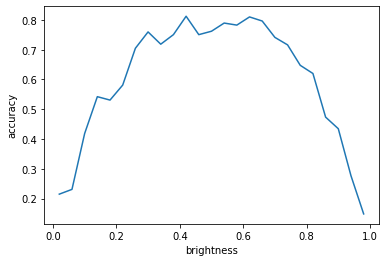

In [0]:
tester.test(brightnessGen)

##### Test zooming

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s] 


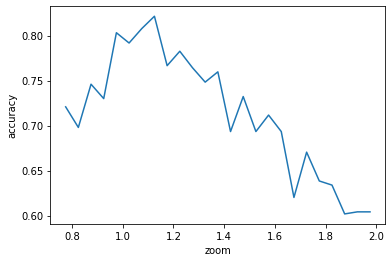

In [0]:
tester.test(zoomGen)

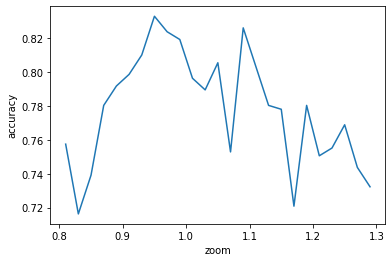

In [0]:
tester.test(zoomGen)

##### Test zoom cropping

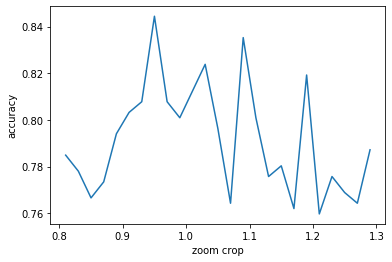

In [0]:
tester.test(zoomCropGen)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


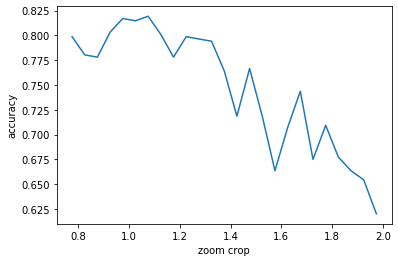

In [0]:
tester.test(zoomCropGen)

##### Test contrast

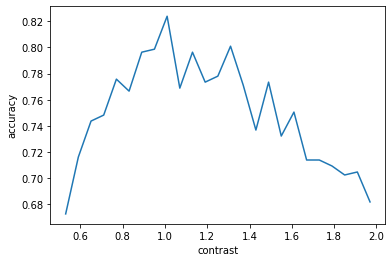

In [0]:
tester.test(contrastGen)

##### Test perspective warping

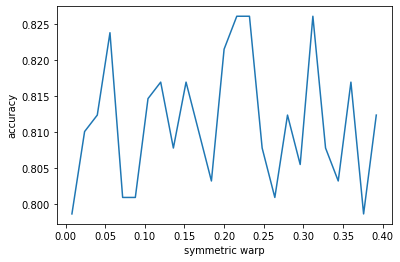

In [0]:
tester.test(warpGen)

##### Test rotating

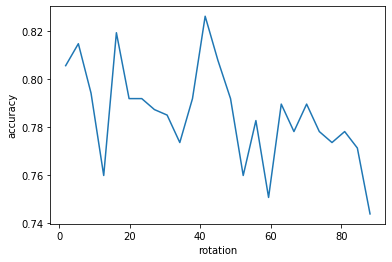

In [0]:
tester.test(rotationGen)

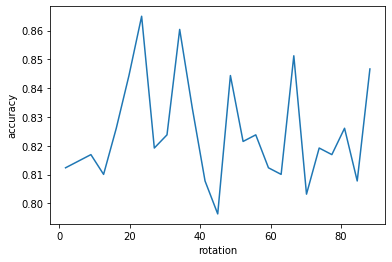

In [0]:
tester.test(rotationGen)

##### Test JPEG compression

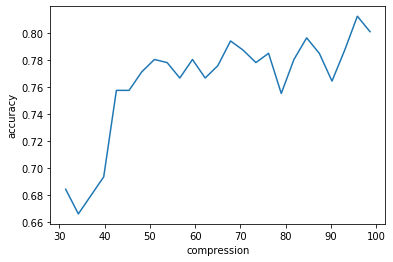

In [0]:
tester.test(compressionGen)

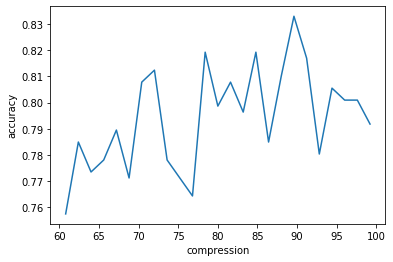

In [0]:
tester.test(compressionGen)

### Test Batch Loss Filter
according to the paper this should speed up the trainig up by 15%
model should converge faster

In [0]:
!git clone https://github.com/oguiza/fastai_extensions.git

Cloning into 'fastai_extensions'...
remote: Enumerating objects: 184, done.
remote: Total 184 (delta 0), reused 0 (delta 0), pack-reused 184
Receiving objects: 100% (184/184), 22.82 MiB | 24.52 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [0]:
%cd fastai_extensions
from fastai_extensions import *
%cd ..

/content/fastai_extensions


/content


In [0]:
import math

class BatchLossFilterCallback(LearnerCallback):
    _order = -20

    def __init__(self, learn:Learner, min_sample_perc:float=0., min_loss_perc:float=0.):
        super().__init__(learn)
        assert min_sample_perc >0. or min_loss_perc > 0., 'min_sample_perc <= 0 and min_loss_perc <= 0'
        self.min_sample_perc, self.min_loss_perc = min_sample_perc, min_loss_perc
        self.learn = learn
        self.model = learn.model
        self.crit = learn.loss_func
        if hasattr(self.crit, 'reduction'):  self.red = self.crit.reduction
        self.sel_losses_sum, self.losses_sum = 0., 0.
        self.sel_samples, self.samples = 0., 0.
        self.recorder.add_metric_names(["loss_perc", "samp_perc"])

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.sel_losses_sum, self.losses_sum = 0., 0.
        self.sel_samples, self.samples = 0., 0.

    def on_batch_begin(self, last_input, last_target, train, epoch, **kwargs):
        if not train or epoch == 0: return
        if hasattr(self.crit, 'reduction'):  setattr(self.crit, 'reduction', 'none')
        with torch.no_grad():  self.losses = np.array(self.crit(self.model(last_input), last_target))
        if hasattr(self.crit, 'reduction'):  setattr(self.crit, 'reduction', self.red)
        self.get_loss_idxs()
        self.sel_losses_sum += self.losses[self.idxs].sum()
        self.losses_sum += self.losses.sum()
        self.sel_samples += len(self.idxs)
        self.samples += len(self.losses)
        return {"last_input": last_input[self.idxs], "last_target": last_target[self.idxs]}

    def on_epoch_end(self, epoch, last_metrics, **kwargs):
        loss_perc = self.sel_losses_sum / self.losses_sum if epoch > 0 else 1.
        sample_perc = self.sel_samples / self.samples if epoch > 0 else 1.
        return add_metrics(last_metrics, [loss_perc, sample_perc])

    def on_train_end(self, **kwargs):
        """At the end of training this calleback will be removed"""
        if hasattr(self.learn.loss_func, 'reduction'):  setattr(self.learn.loss_func, 'reduction', self.red)
        drop_cb_fn(self.learn, 'BatchLossFilterCallback')

    def get_loss_idxs(self):
        idxs = np.argsort(self.losses)[::-1]
        sample_max = math.ceil(len(idxs) * self.min_sample_perc)
        self.losses /= self.losses.sum()
        loss_max = np.argmax(self.losses[idxs].cumsum() >= self.min_loss_perc) + 1
        self.idxs =  list(idxs[:max(sample_max, loss_max)])


def drop_cb_fn(learn, cb_name:str)->None:
    cbs = []
    for cb in learn.callback_fns:
        if isinstance(cb, functools.partial): cbn = cb.func.__name__
        else: cbn = cb.__name__
        if cbn != cb_name: cbs.append(cb)
    learn.callback_fns = cbs


def batch_loss_filter(learn:Learner, min_sample_perc:float=0., min_loss_perc:float=.9)->Learner:
    learn.callback_fns.append(partial(BatchLossFilterCallback, min_sample_perc=min_sample_perc,
                                      min_loss_perc=min_loss_perc))
    return learn

Learner.batch_loss_filter = batch_loss_filter

In [0]:
data = get_data(bs=64)
learn = Learner(data, resnet50, metrics=accuracy).batch_loss_filter()

In [0]:
learn.fit_one_cycle(20, 3e-3, div_factor=10, pct_start=0.3)

In [0]:
data = get_data(bs=32)
learn = Learner(data, resnet50, metrics=accuracy)

In [0]:
learn.fit_one_cycle(20, 3e-3, div_factor=10, pct_start=0.3)

### Heatmap


In [0]:
from fastai.callbacks.hooks import *

In [0]:
data = get_data().normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


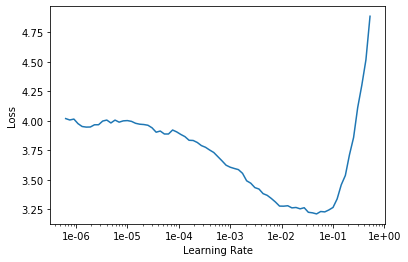

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 3e-3)

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


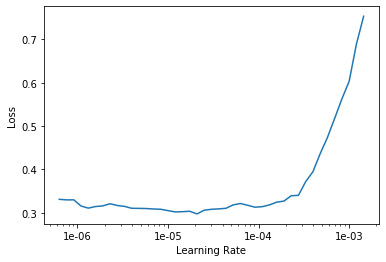

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 5e-5)

In [0]:
m = learn.model.eval();

In [0]:
class ShowHeatMap:
  def __init__(self, learn, idx):
    self.learn = learn
    self.x, self.y = learn.data.valid_ds[idx]

  def hooked_backward(self, m, xb):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(self.y)].backward()
    return hook_a,hook_g 

  def show_heatmap(self, xb_im, hm, ax):
    # _,ax = plt.subplots()
    xb_im.show(ax, title=f"{self.y}")
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

  def process(self, ax):
    m = self.learn.model.eval();
    xb,_ = self.learn.data.one_item(self.x)
    xb_im = Image(data.denorm(xb)[0])
    hook_a,hook_g = self.hooked_backward(m, xb)
    acts  = hook_a.stored[0].cpu()
    avg_acts = acts.mean(0)
    self.show_heatmap(xb_im, avg_acts, ax)

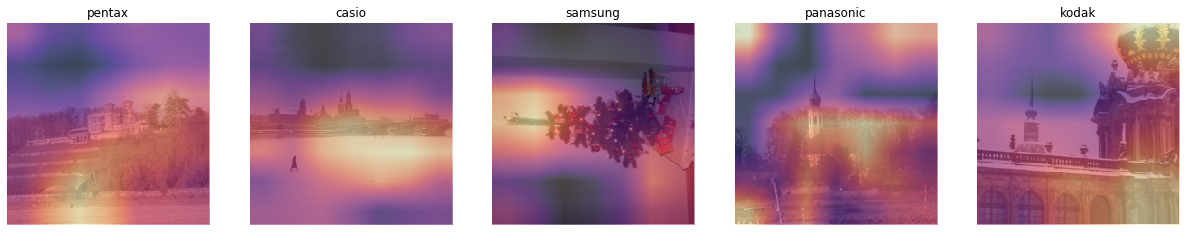

In [0]:
fig, axs = plt.subplots(1,5,figsize=(21,7))
for change, ax in zip(range(5,10), axs):
    ShowHeatMap(learn, change).process(ax)

In [0]:
nikons = [1,2,3,4,15]

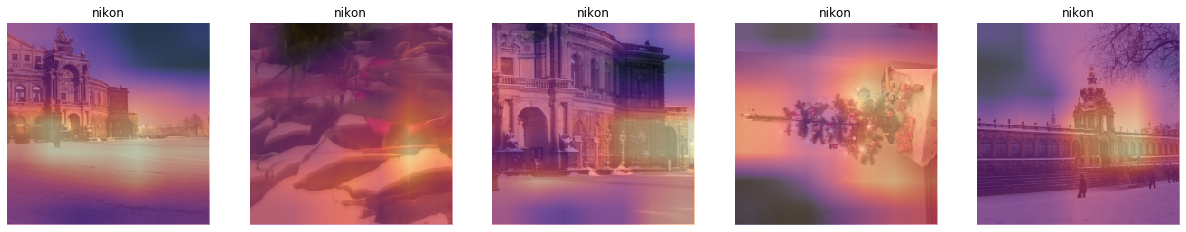

In [0]:
fig, axs = plt.subplots(1,5,figsize=(21,7))
for change, ax in zip(nikons, axs):
    ShowHeatMap(learn, change).process(ax)

In [0]:
learn.predict(learn.data.valid_ds.x[104])

(Category samsung,
 tensor(9),
 tensor([9.6380e-05, 1.3262e-04, 7.7901e-07, 1.2048e-05, 3.9114e-03, 1.2328e-05,
         4.8078e-05, 3.3161e-05, 2.7327e-07, 9.9575e-01, 9.8291e-07]))

Category agfa

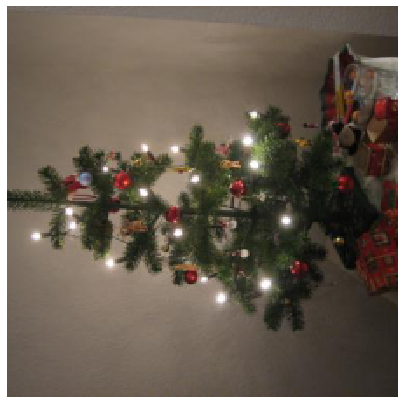

In [0]:
idx=100
x,y = data.valid_ds[idx]
x.show(figsize=(7,10))
data.valid_ds.y[idx]

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
# xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 7, 7])

In [0]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

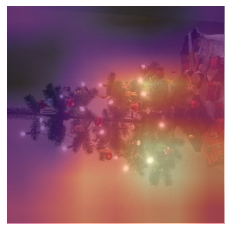

In [0]:
show_heatmap(avg_acts)